<a href="https://colab.research.google.com/github/threegenie/sentiment_project/blob/main/sentiment_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
#mpl.font_manager._rebuild()

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:
# 오류(SettingWithCopyError 발생)
pd.set_option('mode.chained_assignment', 'raise') # SettingWithCopyError

# 경고(SettingWithCopyWarning 발생, 기본 값입니다)
pd.set_option('mode.chained_assignment', 'warn') # SettingWithCopyWarning

# 무시
pd.set_option('mode.chained_assignment',  None) # <==== 경고를 끈다

In [10]:
df = pd.read_table('/review.txt', names=['ratings', 'reviews'])
df

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
...,...,...
199995,2,장마라그런가!!! 달지않아요
199996,5,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...
199997,5,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요
199998,5,넘이쁘고 쎄련되보이네요~


#### 중복 데이터가 있다면 제거

In [11]:
df.drop_duplicates('reviews',keep='first')
df.shape

(200000, 2)

#### 훈련, 테스트셋 분리

In [12]:
train, test = train_test_split(df, test_size = 0.2, random_state = 11)
train.shape, test.shape

((160000, 2), (40000, 2))

#### 별점으로 라벨링 : 별점이 4을 넘으면 긍정 리뷰, 이하는 부정 리뷰로 분류

In [13]:
def star_evaluate(rating):
  if rating >=4:
    return 1
  else:
    return 0
  
train['label'] = train['ratings'].apply(star_evaluate)

train

,ratings,reviews,label
6173,5,머리끝이 많이 갈라져서 구매했습니다. 이미 갈라진 건 어쩔 수 없지만 뭔가 모발이 ...,1
62572,4,"가방사이즈 딱 적절해서 좋고, 탄탄한 느낌이라 좋네요. 다만 새것 냄새가 2일째 빠...",1
102317,2,생각보다 짧아요 ㅠ,0
122006,2,별로따뜻하지도않고..벨브도돌리다밑에캡이빠져버리네여..ㅡㅡ그래서본드로붙였는데..노즐만...,0
111083,1,마스크는소형인데끈이대형이네요ㅎ 그것도 쉽게 끊어져요ㅜ,0
...,...,...,...
102327,1,완전 잘깨져요 이건 뭐 잠깐 바닥에 스치기만해도 깨져있어요,0
97617,2,바코드안떳어요,0
21584,2,네조아요. 필요해서 샀어요,0
36543,5,발열 엄청 오래 지속되고 냄새도 없고 만족합니다,1


In [14]:
train['label'].value_counts()

0    80157
1    79843
Name: label, dtype: int64

#### 데이터 정제 - 훈련, 테스트셋에 모두 적용 -> 정규표현식 사용하여 한글 제외 모두 제거

In [15]:
train['reviews'] = train['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train['reviews'].replace('', np.nan, inplace=True)
train.head()

,ratings,reviews,label
6173,5,머리끝이 많이 갈라져서 구매했습니다 이미 갈라진 건 어쩔 수 없지만 뭔가 모발이 더...,1
62572,4,가방사이즈 딱 적절해서 좋고 탄탄한 느낌이라 좋네요 다만 새것 냄새가 일째 빠지지 ...,1
102317,2,생각보다 짧아요 ㅠ,0
122006,2,별로따뜻하지도않고벨브도돌리다밑에캡이빠져버리네여ㅡㅡ그래서본드로붙였는데노즐만새로사야할듯...,0
111083,1,마스크는소형인데끈이대형이네요ㅎ 그것도 쉽게 끊어져요ㅜ,0


In [16]:
test['reviews'] = test['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test['reviews'].replace('', np.nan, inplace=True)
test.head()

,ratings,reviews
126682,5,조립하기힘들었어요 나사가짧아서
64852,2,ㅜㅜ 제가 인데 ㅜㅜ 진짜 너무너무커요 빨으니까 더 커졌어요ㅜ 잠옷으로 입으려구요
139941,1,만족하는데 배송이 개느림
85091,5,허리받쳐주는건 좋은데 방석이 미끌어져서 뷸편하네용 ㅠ
61522,5,밥을 해도 압력이 안된 밥을 먹었는데 새 패킹으로 갈아끼우니 짱짱하네여내일부터는 밥...


#### 토큰화 - Mecab 사용

In [17]:
mecab = Mecab()

In [18]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [19]:
train['tokenized'] = train['reviews'].apply(mecab.morphs)
train['tokenized'] = train['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [20]:
test['tokenized'] = test['reviews'].apply(mecab.morphs)
test['tokenized'] = test['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [21]:
train.head()

,ratings,reviews,label,tokenized
6173,5,머리끝이 많이 갈라져서 구매했습니다 이미 갈라진 건 어쩔 수 없지만 뭔가 모발이 더...,1,"[머리, 끝, 많이, 갈라져서, 구매, 했, 습니다, 이미, 갈라진, 건, 어쩔, ..."
62572,4,가방사이즈 딱 적절해서 좋고 탄탄한 느낌이라 좋네요 다만 새것 냄새가 일째 빠지지 ...,1,"[가방, 사이즈, 딱, 적절, 해서, 좋, 탄탄, 느낌, 라, 좋, 네요, 다만, ..."
102317,2,생각보다 짧아요 ㅠ,0,"[생각, 보다, 짧, 아요, ㅠ]"
122006,2,별로따뜻하지도않고벨브도돌리다밑에캡이빠져버리네여ㅡㅡ그래서본드로붙였는데노즐만새로사야할듯...,0,"[별로, 따뜻, 않, 벨, 브, 돌리, 밑, 캡, 빠져, 버리, 네여, ㅡㅡ그래서본..."
111083,1,마스크는소형인데끈이대형이네요ㅎ 그것도 쉽게 끊어져요ㅜ,0,"[마스크, 소형, 인데, 끈, 이대형, 네요, ㅎ, 그것, 쉽, 끊, 어, 져요, ㅜ]"


In [22]:
test.head()

,ratings,reviews,tokenized
126682,5,조립하기힘들었어요 나사가짧아서,"[조립, 기, 힘들, 었, 어요, 나사, 짧, 아서]"
64852,2,ㅜㅜ 제가 인데 ㅜㅜ 진짜 너무너무커요 빨으니까 더 커졌어요ㅜ 잠옷으로 입으려구요,"[ㅜㅜ, 제, 인데, ㅜㅜ, 진짜, 너무너무, 커요, 빨, 으니까, 더, 커졌, 어..."
139941,1,만족하는데 배송이 개느림,"[만족, 데, 배송, 개, 느림]"
85091,5,허리받쳐주는건 좋은데 방석이 미끌어져서 뷸편하네용 ㅠ,"[허리, 받쳐, 주, 건, 좋, 은데, 방석, 미끌, 어, 져서, 뷸편하네용, ㅠ]"
61522,5,밥을 해도 압력이 안된 밥을 먹었는데 새 패킹으로 갈아끼우니 짱짱하네여내일부터는 밥...,"[밥, 해도, 압력, 안, 된, 밥, 먹, 었, 는데, 새, 패킹, 으로, 갈아끼우..."


#### 단어 빈도에 따른 시각화

In [23]:
negative_words = np.hstack(train[train.label == 0]['tokenized'].values)
positive_words = np.hstack(train[train.label == 1]['tokenized'].values)

In [24]:
def word_count(docs):
   
    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()

    # 단어가 존재하는 문서의 빈도 카운트, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [25]:
nw = word_count(negative_words)
nw.head(10)

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
5,요,100896,100936,1.0,0.042720,0.042720,0.074009
3,다,51064,51251,2.0,0.021691,0.064411,0.037456
59,어,47015,47131,3.0,0.019948,0.084359,0.034486
37,서,43958,44071,4.0,0.018653,0.103011,0.032244
6,아,42016,42158,5.0,0.017843,0.120854,0.030820
53,이,40504,40706,6.0,0.017228,0.138083,0.029710
70,니,38387,38400,7.0,0.016252,0.154335,0.028158
26,데,36005,36088,8.0,0.015274,0.169609,0.026410
22,네,35674,35688,9.0,0.015105,0.184713,0.026168
80,지,29785,30018,10.0,0.012705,0.197418,0.021848


In [26]:
pw = word_count(positive_words)
pw.head()

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
34,요,101443,101523,1.0,0.054444,0.054444,0.093359
55,아,51146,51317,2.0,0.027520,0.081964,0.047070
14,다,50975,51055,3.0,0.027379,0.109343,0.046913
12,니,43976,44004,4.0,0.023598,0.132941,0.040472
44,좋,42500,42508,5.0,0.022796,0.155737,0.039113


In [27]:
pip install squarify

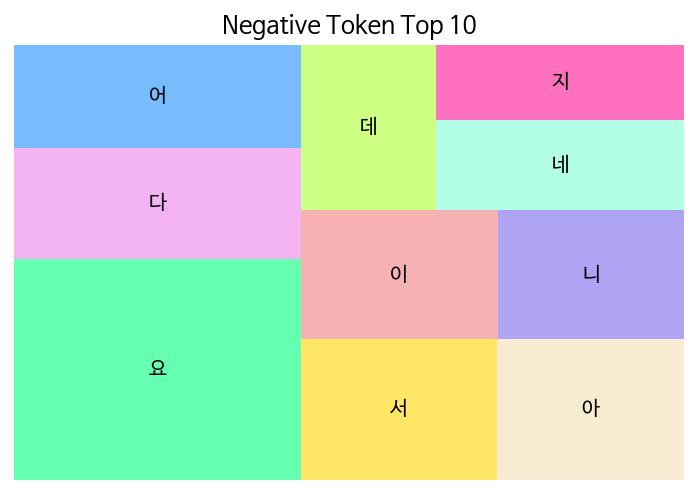

In [28]:
import squarify
import matplotlib.pyplot as plt

colors=['springgreen','violet','dodgerblue','gold','wheat','lightcoral',
        'mediumslateblue','greenyellow','aquamarine','deeppink']

nw_top10 = nw[nw['rank'] <= 10]
squarify.plot(sizes=nw_top10['percent'], label=nw_top10['word'], alpha=0.6, color=colors)
plt.rc('font',family='NanumBarunGothic')
plt.axis('off')
plt.title('Negative Token Top 10')
plt.show()

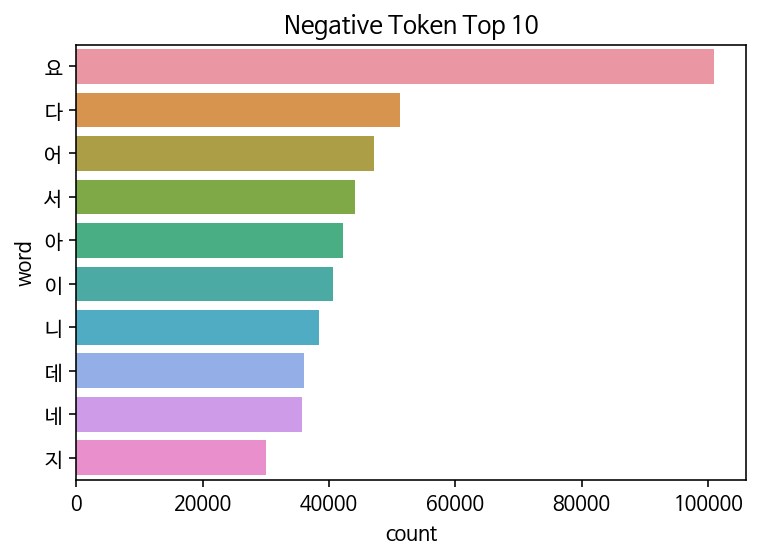

In [31]:
import seaborn as sns
sns.set_palette('GnBu')
sns.barplot(x=nw['count'][:10],y=nw['word'][:10],orient='h')
plt.title('Negative Token Top 10')
plt.show()

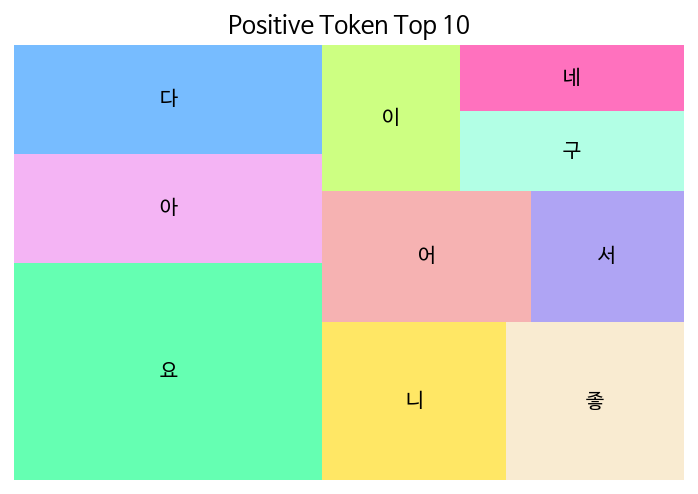

In [29]:
pw_top10 = pw[pw['rank'] <= 10]
squarify.plot(sizes=pw_top10['percent'], label=pw_top10['word'], alpha=0.6, color=colors)
plt.rc('font',family='NanumBarunGothic')
plt.axis('off')
plt.title('Positive Token Top 10')
plt.show()

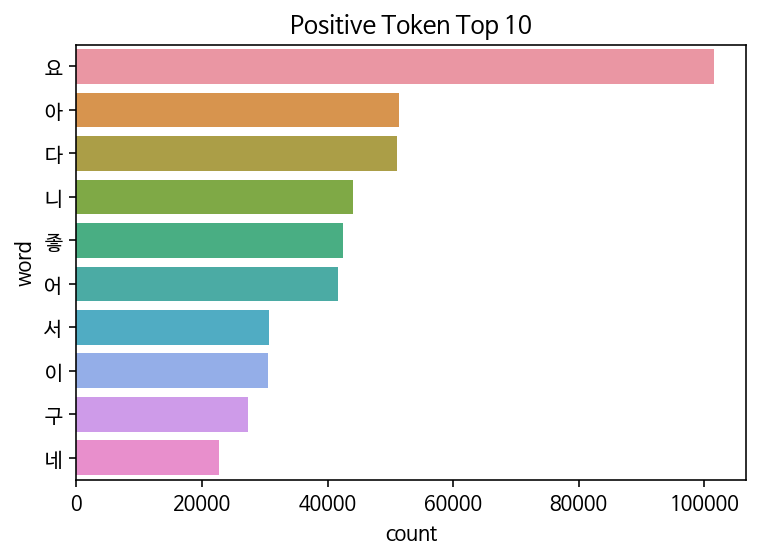

In [32]:
sns.set_palette('GnBu')
sns.barplot(x=pw['count'][:10],y=pw['word'][:10],orient='h')
plt.title('Positive Token Top 10')
plt.show()